In [ ]:
!pip install -U -q PyDrive
  
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
  
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1xNrkZciaQGS38x7dacG9mX05_zfNuWmV/view?usp=sharing'
  
import pandas as pd
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('xclara.csv')  
  
df = pd.read_csv('xclara.csv')
print(df)

       label  pixel0  pixel1  pixel2  ...  pixel780  pixel781  pixel782  pixel783
0         11       0       0       0  ...         0         0         0         0
1         11       2       1       1  ...         0         0         0         0
2         11       1       0       0  ...         0         0         0         0
3         11       0       0       0  ...         0         0         0         0
4         11       0       0       0  ...         0         0         0         0
...      ...     ...     ...     ...  ...       ...       ...       ...       ...
85704     12       0       0       0  ...         0         0         0         0
85705     12       0       0       0  ...         0         0         0         0
85706     12       0       0       0  ...         0         0         0         0
85707     12       0       0       0  ...         0         0         0         0
85708     12       0       0       0  ...         0         0         0         0

[85709 rows x 7

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


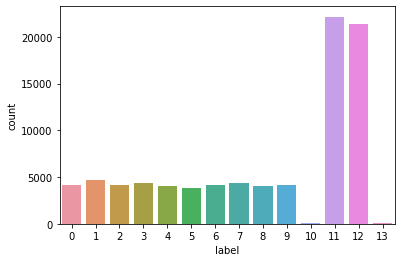

In [ ]:
#~~~1. Data set ~~~

import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import seaborn as sns

np.random.seed(2)

'load the dataset'
dataset = pd.read_csv('xclara.csv')

'creating label'
y = dataset["label"]

'dropping label'
X = dataset.drop(labels = ["label"], axis = 1)

'deleting dataset to reduce memory usage'
del dataset

'overview of dataset'
g = sns.countplot(y)
y.value_counts()

'Grayscale normalization to reduce the effect of illumination differences.'
X = X / 255.0

'reshaping the dataset to fit standard of a 4D tensor of shape [mini-batch size, height = 28px, width = 28px, channels = 1 due to grayscale].'
X = X.values.reshape(-1,28,28,1)

'categorical conversion of label'
y = to_categorical(y, num_classes = 14)

'90% Training and 10% Validation split'
random_seed = 2
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1 , random_state = random_seed, stratify = y)


In [ ]:
from google.colab import files
from IPython.display import Image
uploaded=files.upload()

In [ ]:
#~~~2. Model~~~

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow import keras

'creating the instance of the model'
model = Sequential()

'adding layers to the model'
#Layer: 1
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = "Same", activation = "relu", input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = "Same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#Layer: 2
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "Same", activation = "relu"))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "Same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))


#fully connected layer and output
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(14, activation = "softmax"))



'Set the optimizer and annealer'
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay=0.0 )

model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor = "val_accuracy",
                                            patience = 3,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.0001)


'data augmentation'
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)


'fitting the model'
epochs = 5
batch_size = 86


history = model.fit_generator(
                                datagen.flow(X_train,y_train, batch_size=batch_size),
                                epochs = epochs, #An epoch is an iteration over the entire x and y data provided
                                validation_data = (X_val,y_val), #Data on which to evaluate the loss and any model metrics at the end of each epoch. 
                                verbose = 1, #output
                                steps_per_epoch=X_train.shape[0] // batch_size,  # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.
                                callbacks=[learning_rate_reduction]                            
                              )
'saving the model in HDF5 binary data format'
model.save("/content/gdrive/MyDrive/ColabNotebooks/model.h5")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
896/896 [==============================] - 42s 46ms/step - loss: 0.2743 - accuracy: 0.9165 - val_loss: 0.0769 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 2/5
896/896 [==============================] - 41s 46ms/step - loss: 0.0810 - accuracy: 0.9758 - val_loss: 0.0439 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 3/5
896/896 [==============================] - 40s 45ms/step - loss: 0.0643 - accuracy: 0.9812 - val_loss: 0.0279 - val_accuracy: 0.9918 - lr: 0.0010
Epoch 4/5
896/896 [==============================] - 41s 46ms/step - loss: 0.0577 - accuracy: 0.9836 - val_loss: 0.0328 - val_accuracy: 0.9908 - lr: 0.0010
Epoch 5/5
896/896 [==============================] - 40s 45ms/step - loss: 0.0543 - accuracy: 0.9848 - val_loss: 0.0377 - val_accuracy: 0.9904 - lr: 0.0010


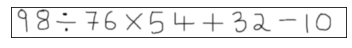

In [ ]:
import os
import cv2
from matplotlib import pyplot as plt

path='testing (2).png'
img = cv2.imread(path,0)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([]) # to hide tick values on X and Y axis
plt.show()


In [ ]:
#~~~3. Prediction~~~

from PIL import Image
from itertools import groupby
import numpy as np
from keras.utils.np_utils import to_categorical
from tensorflow import keras

'loading image in grayscale'
image = Image.open("testing (2).png").convert("L")

'resizing to 28 height pixels'
w = image.size[0]
h = image.size[1]
r = w / h # aspect ratio
new_w = int(r * 28)
new_h = 28
new_image = image.resize((new_w, new_h))

'converting to a numpy array'
new_image_arr = np.array(new_image)

'inverting the image to make background = 0'
new_inv_image_arr = 255 - new_image_arr

'rescaling the image'
final_image_arr = new_inv_image_arr / 255.0

'splitting image array into individual element arrays using non zero columns'
m = final_image_arr.any(0)
out = [final_image_arr[:,[*g]] for k, g in groupby(np.arange(len(m)), lambda x: m[x] != 0) if k]


'''
iterating through the element arrays to resize them to match input 
criteria of the model = [mini_batch_size, height, width, channels]
'''
num_of_elements = len(out)
elements_list = []
for x in range(0, num_of_elements):
    img = out[x]
    
    #adding 0 value columns as fillers
    width = img.shape[1]
    filler = (final_image_arr.shape[0] - width) / 2
    
    if filler.is_integer() == False:    #odd number of filler columns
        filler_l = int(filler)
        filler_r = int(filler) + 1
    else:                               #even number of filler columns
        filler_l = int(filler)
        filler_r = int(filler)
    
    arr_l = np.zeros((final_image_arr.shape[0], filler_l)) #left fillers
    arr_r = np.zeros((final_image_arr.shape[0], filler_r)) #right fillers
    
    #concatinating the left and right fillers
    help_ = np.concatenate((arr_l, img), axis= 1)
    element_arr = np.concatenate((help_, arr_r), axis= 1)
    
    element_arr.resize(28, 28, 1) #resize array 2d to 3d
    #storing all elements in a list
    elements_list.append(element_arr)
elements_array = np.array(elements_list)
'reshaping to fit model input criteria'
elements_array = elements_array.reshape(-1, 28, 28, 1)
'predicting using the created model'
model = keras.models.load_model("/content/gdrive/MyDrive/ColabNotebooks/model.h5")
elements_pred =  model.predict(elements_array)
elements_pred = np.argmax(elements_pred, axis = 1)

In [ ]:
#~~~4. Mathematical Operation~~~

def math_expression_generator(arr):
    
    op = {
              10,   # = "/"
              11,   # = "+"
              12,   # = "-"
              13    # = "*"
                  }   
    
    m_exp = []
    temp = []
        
    'creating a list separating all elements'
    for item in arr:
        if item not in op:
            temp.append(item)
        else:
            m_exp.append(temp)
            m_exp.append(item)
            temp = []
    if temp:
        m_exp.append(temp)
        
    'converting the elements to numbers and operators'
    i = 0
    num = 0
    for item in m_exp:
        if type(item) == list:
            if not item:
                m_exp[i] = ""
                i = i + 1
            else:
                num_len = len(item)
                for digit in item:
                    num_len = num_len - 1
                    num = num + ((10 ** num_len) * digit)
                m_exp[i] = str(num)
                num = 0
                i = i + 1
        else:
            m_exp[i] = str(item)
            m_exp[i] = m_exp[i].replace("10","/")
            m_exp[i] = m_exp[i].replace("11","+")
            m_exp[i] = m_exp[i].replace("12","-")
            m_exp[i] = m_exp[i].replace("13","*")
            
            i = i + 1
    
    
    'joining the list of strings to create the mathematical expression'
    separator = ' '
    m_exp_str = separator.join(m_exp)
    
    return (m_exp_str)

'creating the mathematical expression'
m_exp_str = math_expression_generator(elements_pred)

'calculating the mathematical expression using eval()'
while True:
    try:
        answer = eval(m_exp_str)    #evaluating the answer
        answer = round(answer, 2)
        equation  = m_exp_str + " = " + str(answer)
        print(equation)   #printing the equation
        break

    except SyntaxError:
        print("Invalid predicted expression!!")
        print("Following is the predicted expression:")
        print(m_exp_str)
        break

98 / 76 * 54 + 32 - 10 = 91.63
